In [ ]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib    
import warnings
from tqdm.notebook import tqdm
from haversine import haversine

In [ ]:
## 한글컬럼으로 편집된 자전거 스테이션 이용 현황 가져오기
# df_OH는 스테이션 이용 횟수 / df_OH_haversine 는 스테이션간의 이동 거리를 구해 준다.
df_OH = pd.read_csv('01.운영이력_ver1(한글컬럼, 이용거리).csv',index_col=0) # 스테이션 이용 횟수 구할때 사용
df_Bike= pd.read_csv('02.자전거스테이션.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df_OH['대여 시간']=df_OH['대여 시간'].apply(lambda x : x[:7]) 
df_OH['반납 시간']=df_OH['반납 시간'].apply(lambda x : x[:7]) 

In [ ]:
df_OH

,대여 번호,대여 시간,대여 스테이션 번호,대여 거치대 번호,반납 시간,반납 스테이션 번호,반납 거치대 번호,추정 이동 거리,회원 구분,회원 번호,비회원 번호,자전거 번호,관제 반납,이용 시간(s)
0,15945541,2017-01,213,18,2017-01,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,791.0
1,15945542,2017-01,231,4,2017-01,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2961.0
2,15945543,2017-01,119,14,2017-01,0,0,NaN,12,168994,0.0,1A844000000533,1.0,3600.0
3,15945544,2017-01,121,17,2017-01,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,829.0
4,15945545,2017-01,320,29,2017-01,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142683,21718608,2019-12,222,16,2019-12,219,24,0.0,3,236957,0.0,1A84400000F881,NaN,377.0
3142684,21718610,2019-12,343,14,2019-12,311,15,0.0,99,0,4124665.0,1A84400000F9DA,NaN,240.0
3142685,21718611,2019-12,333,17,2020-01,322,5,0.0,99,0,4124667.0,1A84400000048B,NaN,657.0
3142686,21718613,2019-12,264,4,2020-01,210,13,0.0,12,180671,0.0,1A84400000F804,NaN,685.0


In [ ]:
# 필요한 컬럼들만 뽑아 df_OH_Mon로 만든다.
df_OH_Mon = df_OH[['대여 시간','대여 스테이션 번호','반납 시간','반납 스테이션 번호','추정 이동 거리','이용 시간(s)','회원 번호','비회원 번호']]

In [ ]:
df_OH_Mon # 월별로 운영이력 데이터 정리

,대여 시간,대여 스테이션 번호,반납 시간,반납 스테이션 번호,추정 이동 거리,이용 시간(s),회원 번호,비회원 번호
0,2017-01,213,2017-01,260,0.0,791.0,164203,0.0
1,2017-01,231,2017-01,231,31039.0,2961.0,187551,0.0
2,2017-01,119,2017-01,0,NaN,3600.0,168994,0.0
3,2017-01,121,2017-01,133,15490.0,829.0,183971,0.0
4,2017-01,320,2017-01,259,0.0,912.0,167475,0.0
...,...,...,...,...,...,...,...,...
3142683,2019-12,222,2019-12,219,0.0,377.0,236957,0.0
3142684,2019-12,343,2019-12,311,0.0,240.0,0,4124665.0
3142685,2019-12,333,2020-01,322,0.0,657.0,0,4124667.0
3142686,2019-12,264,2020-01,210,0.0,685.0,180671,0.0


In [ ]:
df_OH_Mon_Mem = df_OH_Mon[df_OH_Mon['회원 번호']!=0] # 회원들만 뽑아내준다.

## 대여 시간을 기준으로 스테이션 별 월별 대여 및 반납 스테이션 이용 횟수를 구해준다.

In [ ]:
df_OH_Mon['대여 스테이션 번호']=df_OH_Mon[['대여 스테이션 번호']].astype('str')
df_OH_Mon['반납 스테이션 번호']=df_OH_Mon[['반납 스테이션 번호']].astype('str')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 스테이션 칼럼 만들어 주기

#### 대여 스테이션 번호

In [ ]:
df_station_name_0 = df_OH_Mon['대여 스테이션 번호'].unique().tolist()
df_station_name_0.sort() 
len(df_station_name_0)
df_station_name_rent = pd.DataFrame(df_station_name_0, columns=['스테이션 번호'])
df_station_name_rent

,스테이션 번호
0,101
1,103
2,104
3,105
4,106
...,...
151,349
152,350
153,351
154,992


#### 반납 스테이션 번호

In [ ]:
df_station_name_1 = df_OH_Mon['반납 스테이션 번호'].unique().tolist()
df_station_name_1.sort() 
len(df_station_name_1)
df_station_name_return = pd.DataFrame(df_station_name_1, columns=['스테이션 번호'])
df_station_name_return

,스테이션 번호
0,0
1,101
2,103
3,104
4,105
...,...
153,350
154,351
155,992
156,998


#### 대여

In [ ]:
# 3년치 데이터 월별로 분리 / dataframe 합쳐주기
M_2017_01 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-01'][:156].reset_index()['대여 시간']
df_2017_01= pd.concat([M_2017_01, df_station_name_rent ],axis=1)
M_2017_02 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-02'][:156].reset_index()['대여 시간']
df_2017_02= pd.concat([M_2017_02, df_station_name_rent ],axis=1)
M_2017_03 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-03'][:156].reset_index()['대여 시간']
df_2017_03= pd.concat([M_2017_03, df_station_name_rent ],axis=1)
M_2017_04 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-04'][:156].reset_index()['대여 시간']
df_2017_04= pd.concat([M_2017_04, df_station_name_rent ],axis=1)
M_2017_05 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-05'][:156].reset_index()['대여 시간']
df_2017_05= pd.concat([M_2017_05, df_station_name_rent ],axis=1)
M_2017_06 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-06'][:156].reset_index()['대여 시간']
df_2017_06= pd.concat([M_2017_06, df_station_name_rent ],axis=1)
M_2017_07 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-07'][:156].reset_index()['대여 시간']
df_2017_07= pd.concat([M_2017_07, df_station_name_rent ],axis=1)
M_2017_08 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-08'][:156].reset_index()['대여 시간']
df_2017_08= pd.concat([M_2017_08, df_station_name_rent ],axis=1)
M_2017_09 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-09'][:156].reset_index()['대여 시간']
df_2017_09= pd.concat([M_2017_09, df_station_name_rent ],axis=1)
M_2017_10 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-10'][:156].reset_index()['대여 시간']
df_2017_10= pd.concat([M_2017_10, df_station_name_rent ],axis=1)
M_2017_11 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-11'][:156].reset_index()['대여 시간']
df_2017_11= pd.concat([M_2017_11, df_station_name_rent ],axis=1)
M_2017_12 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-12'][:156].reset_index()['대여 시간']
df_2017_12= pd.concat([M_2017_12, df_station_name_rent ],axis=1)
M_2018_01 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-01'][:156].reset_index()['대여 시간']
df_2018_01= pd.concat([M_2018_01, df_station_name_rent ],axis=1)
M_2018_02 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-02'][:156].reset_index()['대여 시간']
df_2018_02= pd.concat([M_2018_02, df_station_name_rent ],axis=1)
M_2018_03 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-03'][:156].reset_index()['대여 시간']
df_2018_03= pd.concat([M_2018_03, df_station_name_rent ],axis=1)
M_2018_04 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-04'][:156].reset_index()['대여 시간']
df_2018_04= pd.concat([M_2018_04, df_station_name_rent ],axis=1)
M_2018_05 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-05'][:156].reset_index()['대여 시간']
df_2018_05= pd.concat([M_2018_05, df_station_name_rent ],axis=1)
M_2018_06 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-06'][:156].reset_index()['대여 시간']
df_2018_06= pd.concat([M_2018_06, df_station_name_rent ],axis=1)
M_2018_07 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-07'][:156].reset_index()['대여 시간']
df_2018_07= pd.concat([M_2018_07, df_station_name_rent ],axis=1)
M_2018_08 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-08'][:156].reset_index()['대여 시간']
df_2018_08= pd.concat([M_2018_08, df_station_name_rent ],axis=1)
M_2018_09 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-09'][:156].reset_index()['대여 시간']
df_2018_09= pd.concat([M_2018_09, df_station_name_rent ],axis=1)
M_2018_10 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-10'][:156].reset_index()['대여 시간']
df_2018_10= pd.concat([M_2018_10, df_station_name_rent ],axis=1)
M_2018_11 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-11'][:156].reset_index()['대여 시간']
df_2018_11= pd.concat([M_2018_11, df_station_name_rent ],axis=1)
M_2018_12 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-12'][:156].reset_index()['대여 시간']
df_2018_12= pd.concat([M_2018_12, df_station_name_rent ],axis=1)
M_2019_01 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-01'][:156].reset_index()['대여 시간']
df_2019_01= pd.concat([M_2019_01, df_station_name_rent ],axis=1)
M_2019_02 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-02'][:156].reset_index()['대여 시간']
df_2019_02= pd.concat([M_2019_02, df_station_name_rent ],axis=1)
M_2019_03 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-03'][:156].reset_index()['대여 시간']
df_2019_03= pd.concat([M_2019_03, df_station_name_rent ],axis=1)
M_2019_04 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-04'][:156].reset_index()['대여 시간']
df_2019_04= pd.concat([M_2019_04, df_station_name_rent ],axis=1)
M_2019_05 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-05'][:156].reset_index()['대여 시간']
df_2019_05= pd.concat([M_2019_05, df_station_name_rent ],axis=1)
M_2019_06 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-06'][:156].reset_index()['대여 시간']
df_2019_06= pd.concat([M_2019_06, df_station_name_rent ],axis=1)
M_2019_07 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-07'][:156].reset_index()['대여 시간']
df_2019_07= pd.concat([M_2019_07, df_station_name_rent ],axis=1)
M_2019_08 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-08'][:156].reset_index()['대여 시간']
df_2019_08= pd.concat([M_2019_08, df_station_name_rent ],axis=1)
M_2019_09 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-09'][:156].reset_index()['대여 시간']
df_2019_09= pd.concat([M_2019_09, df_station_name_rent ],axis=1)
M_2019_10 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-10'][:156].reset_index()['대여 시간']
df_2019_10= pd.concat([M_2019_10, df_station_name_rent ],axis=1)
M_2019_11 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-11'][:156].reset_index()['대여 시간']
df_2019_11= pd.concat([M_2019_11, df_station_name_rent ],axis=1)
M_2019_12 =df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-12'][:156].reset_index()['대여 시간']
df_2019_12= pd.concat([M_2019_12, df_station_name_rent ],axis=1)

In [ ]:
df_station_name_rent_Mon = pd.concat([df_2017_01, df_2017_02, df_2017_03, df_2017_04, df_2017_05, df_2017_06, df_2017_07, df_2017_08, df_2017_09, df_2017_10, df_2017_11, df_2017_12, df_2018_01, df_2018_02, df_2018_03, df_2018_04, df_2018_05, df_2018_06, df_2018_07, df_2018_08, df_2018_09, df_2018_10,df_2018_11, df_2018_12, df_2019_01, df_2019_02, df_2019_03, df_2019_04, df_2019_05, df_2019_06, df_2019_07, df_2019_08, df_2019_09, df_2019_10, df_2019_11, df_2019_12],axis=0)
df_station_name_rent_Mon

,대여 시간,스테이션 번호
0,2017-01,101
1,2017-01,103
2,2017-01,104
3,2017-01,105
4,2017-01,106
...,...,...
151,2019-12,349
152,2019-12,350
153,2019-12,351
154,2019-12,992


In [ ]:
df_station_name_rent_Mon.reset_index(drop=True, inplace=True)

#### 반납

In [ ]:
# 3년치 데이터 월별로 분리 / dataframe 합쳐주기
M_2017_01 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-01'][:158].reset_index()['반납 시간']
df_2017_01= pd.concat([M_2017_01, df_station_name_return ],axis=1)
M_2017_02 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-02'][:158].reset_index()['반납 시간']
df_2017_02= pd.concat([M_2017_02, df_station_name_return ],axis=1)
M_2017_03 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-03'][:158].reset_index()['반납 시간']
df_2017_03= pd.concat([M_2017_03, df_station_name_return ],axis=1)
M_2017_04 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-04'][:158].reset_index()['반납 시간']
df_2017_04= pd.concat([M_2017_04, df_station_name_return ],axis=1)
M_2017_05 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-05'][:158].reset_index()['반납 시간']
df_2017_05= pd.concat([M_2017_05, df_station_name_return ],axis=1)
M_2017_06 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-06'][:158].reset_index()['반납 시간']
df_2017_06= pd.concat([M_2017_06, df_station_name_return ],axis=1)
M_2017_07 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-07'][:158].reset_index()['반납 시간']
df_2017_07= pd.concat([M_2017_07, df_station_name_return ],axis=1)
M_2017_08 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-08'][:158].reset_index()['반납 시간']
df_2017_08= pd.concat([M_2017_08, df_station_name_return ],axis=1)
M_2017_09 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-09'][:158].reset_index()['반납 시간']
df_2017_09= pd.concat([M_2017_09, df_station_name_return ],axis=1)
M_2017_10 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-10'][:158].reset_index()['반납 시간']
df_2017_10= pd.concat([M_2017_10, df_station_name_return ],axis=1)
M_2017_11 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-11'][:158].reset_index()['반납 시간']
df_2017_11= pd.concat([M_2017_11, df_station_name_return ],axis=1)
M_2017_12 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2017-12'][:158].reset_index()['반납 시간']
df_2017_12= pd.concat([M_2017_12, df_station_name_return ],axis=1)
M_2018_01 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-01'][:158].reset_index()['반납 시간']
df_2018_01= pd.concat([M_2018_01, df_station_name_return ],axis=1)
M_2018_02 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-02'][:158].reset_index()['반납 시간']
df_2018_02= pd.concat([M_2018_02, df_station_name_return ],axis=1)
M_2018_03 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-03'][:158].reset_index()['반납 시간']
df_2018_03= pd.concat([M_2018_03, df_station_name_return ],axis=1)
M_2018_04 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-04'][:158].reset_index()['반납 시간']
df_2018_04= pd.concat([M_2018_04, df_station_name_return ],axis=1)
M_2018_05 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-05'][:158].reset_index()['반납 시간']
df_2018_05= pd.concat([M_2018_05, df_station_name_return ],axis=1)
M_2018_06 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-06'][:158].reset_index()['반납 시간']
df_2018_06= pd.concat([M_2018_06, df_station_name_return ],axis=1)
M_2018_07 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-07'][:158].reset_index()['반납 시간']
df_2018_07= pd.concat([M_2018_07, df_station_name_return ],axis=1)
M_2018_08 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-08'][:158].reset_index()['반납 시간']
df_2018_08= pd.concat([M_2018_08, df_station_name_return ],axis=1)
M_2018_09 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-09'][:158].reset_index()['반납 시간']
df_2018_09= pd.concat([M_2018_09, df_station_name_return ],axis=1)
M_2018_10 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-10'][:158].reset_index()['반납 시간']
df_2018_10= pd.concat([M_2018_10, df_station_name_return ],axis=1)
M_2018_11 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-11'][:158].reset_index()['반납 시간']
df_2018_11= pd.concat([M_2018_11, df_station_name_return ],axis=1)
M_2018_12 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2018-12'][:158].reset_index()['반납 시간']
df_2018_12= pd.concat([M_2018_12, df_station_name_return ],axis=1)
M_2019_01 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-01'][:158].reset_index()['반납 시간']
df_2019_01= pd.concat([M_2019_01, df_station_name_return ],axis=1)
M_2019_02 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-02'][:158].reset_index()['반납 시간']
df_2019_02= pd.concat([M_2019_02, df_station_name_return ],axis=1)
M_2019_03 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-03'][:158].reset_index()['반납 시간']
df_2019_03= pd.concat([M_2019_03, df_station_name_return ],axis=1)
M_2019_04 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-04'][:158].reset_index()['반납 시간']
df_2019_04= pd.concat([M_2019_04, df_station_name_return ],axis=1)
M_2019_05 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-05'][:158].reset_index()['반납 시간']
df_2019_05= pd.concat([M_2019_05, df_station_name_return ],axis=1)
M_2019_06 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-06'][:158].reset_index()['반납 시간']
df_2019_06= pd.concat([M_2019_06, df_station_name_return ],axis=1)
M_2019_07 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-07'][:158].reset_index()['반납 시간']
df_2019_07= pd.concat([M_2019_07, df_station_name_return ],axis=1)
M_2019_08 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-08'][:158].reset_index()['반납 시간']
df_2019_08= pd.concat([M_2019_08, df_station_name_return ],axis=1)
M_2019_09 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-09'][:158].reset_index()['반납 시간']
df_2019_09= pd.concat([M_2019_09, df_station_name_return ],axis=1)
M_2019_10 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-10'][:158].reset_index()['반납 시간']
df_2019_10= pd.concat([M_2019_10, df_station_name_return ],axis=1)
M_2019_11 = df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-11'][:158].reset_index()['반납 시간']
df_2019_11= pd.concat([M_2019_11, df_station_name_return ],axis=1)
M_2019_12 =df_OH_Mon[df_OH_Mon['대여 시간'] == '2019-12'][:158].reset_index()['반납 시간']
df_2019_12= pd.concat([M_2019_12, df_station_name_return ],axis=1)

In [ ]:
df_station_name_return_Mon = pd.concat([df_2017_01, df_2017_02, df_2017_03, df_2017_04, df_2017_05, df_2017_06, df_2017_07, df_2017_08, df_2017_09, df_2017_10, df_2017_11, df_2017_12, df_2018_01, df_2018_02, df_2018_03, df_2018_04, df_2018_05, df_2018_06, df_2018_07, df_2018_08, df_2018_09, df_2018_10,df_2018_11, df_2018_12, df_2019_01, df_2019_02, df_2019_03, df_2019_04, df_2019_05, df_2019_06, df_2019_07, df_2019_08, df_2019_09, df_2019_10, df_2019_11, df_2019_12],axis=0)
df_station_name_return_Mon

,반납 시간,스테이션 번호
0,2017-01,0
1,2017-01,101
2,2017-01,103
3,2017-01,104
4,2017-01,105
...,...,...
153,2019-12,350
154,2019-12,351
155,2019-12,992
156,2019-12,998


In [ ]:
df_station_name_return_Mon.reset_index(drop=True, inplace=True)

### 월 기준 스테이션 별 대여 스테이션 이용 횟수 구해주기

In [ ]:
month_hour = df_OH_Mon['대여 시간'].unique().tolist()
month_hour

#### 전체인원

In [ ]:
BikeStation_use_Mon_rent = [] # 월별 대여 스테이션 이용 현황
for i in tqdm(month_hour):
    for j in df_station_name_0:
        BikeStation_use_Mon_rent.append(((df_OH_Mon['대여 시간']==i)&(df_OH_Mon['대여 스테이션 번호']==j)).sum())

In [ ]:
df_BikeStation_use_Mon_rent = pd.DataFrame(BikeStation_use_Mon_rent, columns=['대여 스테이션 이용 횟수'])
df_BikeStation_use_Mon_rent

,대여 스테이션 이용 횟수
0,80
1,33
2,152
3,27
4,62
...,...
5611,133
5612,54
5613,157
5614,19


#### 회원

In [ ]:
BikeStation_use_Mon_Mem_rent = [] # 월별 대여 스테이션 이용 현황
for i in tqdm(month_hour):
    for j in df_station_name_0:
        BikeStation_use_Mon_Mem_rent.append(((df_OH_Mon_Mem['대여 시간']==i)&(df_OH_Mon_Mem['대여 스테이션 번호']==j)).sum())

In [ ]:
df_BikeStation_use_Mon_Mem_rent = pd.DataFrame(BikeStation_use_Mon_Mem_rent, columns=['회원 대여 스테이션 이용 횟수'])
df_BikeStation_use_Mon_Mem_rent

,회원 대여 스테이션 이용 횟수
0,49
1,18
2,120
3,21
4,51
...,...
5611,100
5612,47
5613,141
5614,19


#### 대여 데이터 merge

In [ ]:
df_BikeStation_use_Mon_rent_all_1 = pd.concat([df_station_name_rent_Mon,df_BikeStation_use_Mon_rent,df_BikeStation_use_Mon_Mem_rent],axis=1)
df_BikeStation_use_Mon_rent_all = df_BikeStation_use_Mon_rent_all_1.assign(TEST=lambda x: (x['대여 스테이션 이용 횟수']-x['회원 대여 스테이션 이용 횟수']))
df_BikeStation_use_Mon_rent_all.columns = ['대여 시간','스테이션 번호','대여 스테이션 이용 횟수','회원 대여 스테이션 이용 횟수','바회원 대여 스테이션 이용 횟수']
df_BikeStation_use_Mon_rent_all

,대여 시간,스테이션 번호,대여 스테이션 이용 횟수,회원 대여 스테이션 이용 횟수,바회원 대여 스테이션 이용 횟수
0,2017-01,101,80,49,31
1,2017-01,103,33,18,15
2,2017-01,104,152,120,32
3,2017-01,105,27,21,6
4,2017-01,106,62,51,11
...,...,...,...,...,...
5611,2019-12,349,133,100,33
5612,2019-12,350,54,47,7
5613,2019-12,351,157,141,16
5614,2019-12,992,19,19,0


### 월 기준 스테이션 별 반납 스테이션 이용 횟수 구해주기

#### 전체인원

In [ ]:
BikeStation_use_Mon_return = [] # 월별 반납 스테이션 이용 현황
for i in tqdm(month_hour):
    for j in df_station_name_1:
        BikeStation_use_Mon_return.append(((df_OH_Mon['반납 시간']==i)&(df_OH_Mon['반납 스테이션 번호']==j)).sum())

In [ ]:
df_BikeStation_use_Mon_return = pd.DataFrame(BikeStation_use_Mon_return, columns=['반납 스테이션 이용 횟수'])
df_BikeStation_use_Mon_return

,반납 스테이션 이용 횟수
0,3823
1,109
2,44
3,89
4,17
...,...
5683,37
5684,149
5685,19
5686,1


#### 회원

In [ ]:
BikeStation_use_Mon_Mem_return = [] # 월별 반납 스테이션 이용 현황
for i in tqdm(month_hour):
    for j in df_station_name_1:
        BikeStation_use_Mon_Mem_return.append(((df_OH_Mon_Mem['반납 시간']==i)&(df_OH_Mon_Mem['반납 스테이션 번호']==j)).sum())

In [ ]:
df_BikeStation_use_Mon_Mem_return = pd.DataFrame(BikeStation_use_Mon_Mem_return, columns=['회원 반납 스테이션 이용 횟수'])
df_BikeStation_use_Mon_Mem_return

,회원 반납 스테이션 이용 횟수
0,3237
1,68
2,22
3,64
4,13
...,...
5683,30
5684,110
5685,18
5686,1


#### 반납 데이터 merge

In [ ]:

df_BikeStation_use_Mon_return_all_1 = pd.concat([df_station_name_return_Mon,df_BikeStation_use_Mon_return,df_BikeStation_use_Mon_Mem_return],axis=1)
df_BikeStation_use_Mon_return_all = df_BikeStation_use_Mon_return_all_1.assign(TEST=lambda x: (x['반납 스테이션 이용 횟수']-x['회원 반납 스테이션 이용 횟수']))
df_BikeStation_use_Mon_return_all.columns = ['대여 시간','스테이션 번호','반납 스테이션 이용 횟수','반납 대여 스테이션 이용 횟수','바회원 반납 스테이션 이용 횟수']
df_BikeStation_use_Mon_return_all

,대여 시간,스테이션 번호,반납 스테이션 이용 횟수,반납 대여 스테이션 이용 횟수,바회원 반납 스테이션 이용 횟수
0,2017-01,0,3823,3237,586
1,2017-01,101,109,68,41
2,2017-01,103,44,22,22
3,2017-01,104,89,64,25
4,2017-01,105,17,13,4
...,...,...,...,...,...
5683,2019-12,350,37,30,7
5684,2019-12,351,149,110,39
5685,2019-12,992,19,18,1
5686,2019-12,998,1,1,0


### haversine 함수를 통해 스테이션간의 직선거리 구하기

In [ ]:
df_Bike

,Station_ID,STATION_NAME,거치대 수량,위도,경도
0,101,어울림마을 701동 앞,20,37.654775,126.834584
1,103,대림e-편한세상106동,20,37.660442,126.840377
2,104,탄현마을8단지,25,37.698523,126.766042
3,105,KT 덕양지사 앞,20,37.655244,126.839261
4,106,원당역 앞 공영주차장,30,37.653410,126.842530
...,...,...,...,...,...
159,350,★하이파크5단지 502동앞 버스정류장,20,37.697867,126.753089
160,351,◆일산에듀포레 푸르지오,40,37.702259,126.767231
161,352,◆꿈에그린203동앞,40,37.666425,126.749244
162,353,◆꿈에그린106동앞,40,37.666720,126.750784


In [ ]:
# haversine 식을 이용하요 스테이션 간의 거리(m단위로)
station_1 = []
station_2 = []
harv = []
for sta, lat, long in zip(df_Bike['Station_ID'],df_Bike['위도'],df_Bike['경도']):
    for sta1, lat1, long1 in zip(df_Bike['Station_ID'],df_Bike['위도'],df_Bike['경도']):
        x = (lat, long)
        y = (lat1, long1) 
        h = haversine(x, y) *1000
        station_1.append(sta)
        station_2.append(sta1)
        harv.append(h)

In [ ]:
# 리스트를 데이터 프레임 후 컬럼 생성 
df_sta_1 = pd.DataFrame(station_1, columns=['sta_rent']) # 대여 스테이션
df_sta_2 = pd.DataFrame(station_2, columns=['sta_return']) # 반납 스테이션
df_harv = pd.DataFrame(harv, columns=['이동거리']) # haversine 이동거리

In [ ]:
df_haversine_distance = pd.concat([df_sta_1,df_sta_2, df_harv], axis = 1)
df_haversine_distance

,sta_rent,sta_return,이동거리
0,101,101,0.000000
1,101,103,810.593473
2,101,104,7749.401651
3,101,105,414.953376
4,101,106,715.798911
...,...,...,...
26891,992,350,9768.976190
26892,992,351,9278.739241
26893,992,352,8104.699800
26894,992,353,7993.663782


### 총 스테이션 이용 횟수

#### 총 대여 스테이션 이용 횟수

In [ ]:
# 스테이션 기준으로 3년간 대여 스테이션 이용 횟수
station_rent_count = (df_OH.groupby(df_OH['대여 스테이션 번호'])).count()
df_station_rent_count = station_rent_count[['대여 시간']]
df_station_rent_count.columns = ['전체 인원 대여 스테이션 이용 횟수']
df_station_rent_totalcount_end = df_station_rent_count.reset_index()
df_station_rent_totalcount_end

,대여 스테이션 번호,전체 인원 대여 스테이션 이용 횟수
0,101,8366
1,103,4535
2,104,13402
3,105,2806
4,106,4444
...,...,...
151,349,7532
152,350,4190
153,351,473
154,992,952


In [ ]:
# 스테이션 기준으로 회원들의 대여 스테이션 이용 횟수
station_rent_count_Mem = (df_OH_Mon_Mem.groupby(df_OH_Mon_Mem['대여 스테이션 번호'])).count()
station_rent_count_Mem_1 = station_rent_count_Mem[['대여 시간']]
station_rent_count_Mem_1.columns = ['회원 대여 스테이션 이용 횟수']
station_rent_count_Mem_end = station_rent_count_Mem_1.reset_index()
station_rent_count_Mem_end


,대여 스테이션 번호,회원 대여 스테이션 이용 횟수
0,101,5494
1,103,2460
2,104,10163
3,105,1930
4,106,3349
...,...,...
151,349,5822
152,350,3219
153,351,418
154,992,928


In [ ]:
df_station_rent_count_1 = pd.merge(df_station_rent_totalcount_end,station_rent_count_Mem_end,on='대여 스테이션 번호',how='left')
df_station_rent_count_end = df_station_rent_count_1.assign(TEST=lambda x: (x['전체 인원 대여 스테이션 이용 횟수'] - x['회원 대여 스테이션 이용 횟수']))
df_station_rent_count_end.columns = ['대여 스테이션 번호','전체 인원 대여 스테이션 이용 횟수','회원 대여 스테이션 이용 횟수','비회원 대여 스테이션 이용 횟수']

#### 3년간 반납 스테이션 이용 현황

In [ ]:
# 스테이션 기준으로 3년간 반납 스테이션 이용 횟수
station_return_count = (df_OH.groupby(df_OH['반납 스테이션 번호'])).count()
df_station_return_count = station_return_count[['대여 시간']]
df_station_return_count.columns = ['전체 인원 반납 스테이션 이용 횟수']
df_station_return_count_end = df_station_return_count.reset_index()
df_station_return_count_end

,반납 스테이션 번호,전체 인원 반납 스테이션 이용 횟수
0,0,398234
1,101,9207
2,103,5121
3,104,9330
4,105,2696
...,...,...
153,350,3662
154,351,406
155,992,795
156,998,21


In [ ]:
# 스테이션 기준으로 회원들의 반납 스테이션 이용 횟수
df_station_return_count_Mem = (df_OH_Mon_Mem.groupby(df_OH_Mon_Mem['반납 스테이션 번호'])).count()
df_station_return_count_Mem_1 = df_station_return_count_Mem[['대여 시간']]
df_station_return_count_Mem_1.columns = ['회원 반납 스테이션 이용 횟수']
df_station_return_count_Mem_end = df_station_return_count_Mem_1.reset_index()
df_station_return_count_Mem_end


,반납 스테이션 번호,회원 반납 스테이션 이용 횟수
0,0,311324
1,101,5726
2,103,2410
3,104,6801
4,105,1759
...,...,...
153,350,2765
154,351,318
155,992,754
156,998,21


In [ ]:
df_station_return_count_1 = pd.merge(df_station_return_count_end,df_station_return_count_Mem_end,on='반납 스테이션 번호',how='left')
df_station_return_count_end = df_station_return_count_1.assign(TEST=lambda x: (x['전체 인원 반납 스테이션 이용 횟수'] - x['회원 반납 스테이션 이용 횟수']))
df_station_return_count_end.columns = ['반납 스테이션 번호','전체 인원 반납 스테이션 이용 횟수','회원 반납 스테이션 이용 횟수','비회원 반납 스테이션 이용 횟수']

### 데이터 시각화

#### 3년간 총 대여 스테이션 시각화

In [ ]:
df_station_rent_count_end

,대여 스테이션 번호,전체 인원 대여 스테이션 이용 횟수,회원 대여 스테이션 이용 횟수,비회원 대여 스테이션 이용 횟수
0,101,8366,5494,2872
1,103,4535,2460,2075
2,104,13402,10163,3239
3,105,2806,1930,876
4,106,4444,3349,1095
...,...,...,...,...
151,349,7532,5822,1710
152,350,4190,3219,971
153,351,473,418,55
154,992,952,928,24


In [ ]:
df_station_rent_count_end['대여 스테이션 번호'] = df_station_rent_count_end[['대여 스테이션 번호']].astype('str')

In [ ]:
df_station_rent_count_end.describe()

,전체 인원 대여 스테이션 이용 횟수,회원 대여 스테이션 이용 횟수,비회원 대여 스테이션 이용 횟수
count,156.000000,156.000000,156.000000
mean,20145.435897,15066.019231,5079.416667
std,17664.268255,12960.981392,6771.083592
min,25.000000,25.000000,0.000000
25%,7870.500000,5380.500000,2016.000000
50%,13411.500000,10147.000000,3487.500000
75%,28972.000000,23831.250000,5261.250000
max,83134.000000,66217.000000,53377.000000


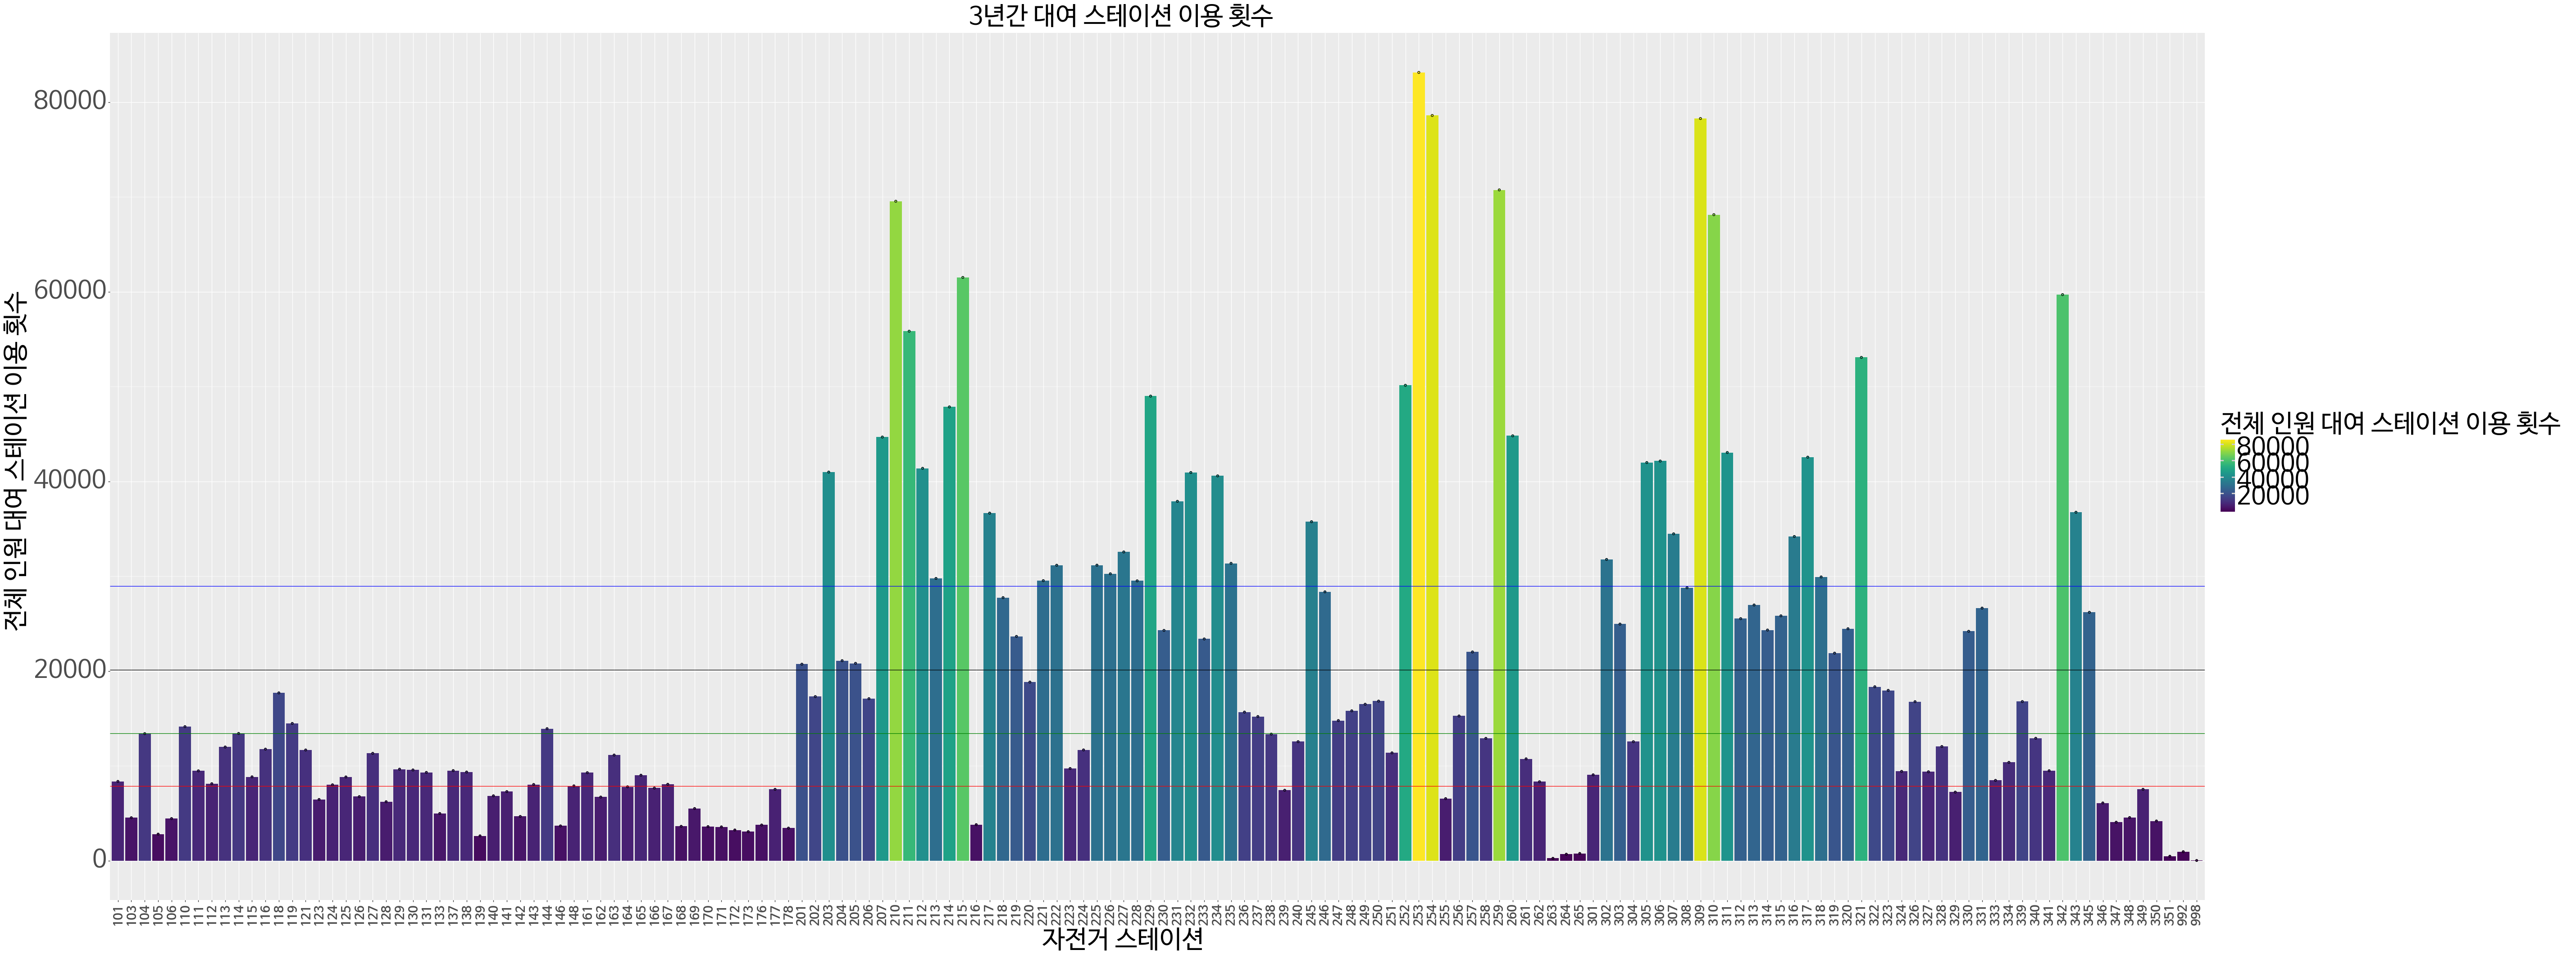

<ggplot: (-9223363307327060420)>

In [ ]:
(ggplot(df_station_rent_count_end)
+ aes(x = '대여 스테이션 번호', y = '전체 인원 대여 스테이션 이용 횟수', fill = '전체 인원 대여 스테이션 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ geom_hline(yintercept = 7870.500000,color='red',size=0.5) # 25
 + geom_hline(yintercept = 13411.500000	,color='green',size=0.5) #50
+ geom_hline(yintercept = 28972.000000	,color='blue',size=0.5) # 75
 + geom_hline(yintercept = 20145.435897, color='black',size=0.5) #평균
+ labs(x='자전거 스테이션', y='전체 인원 대여 스테이션 이용 횟수', title = '3년간 대여 스테이션 이용 횟수 ')
+ theme(text = element_text(family = "NanumBarunGothic",size=40), axis_text_x = element_text(size =20,face = 'bold',angle = 90), figure_size = (60,25))
)

In [ ]:
# thide quartile
df_station_rent_count_third = df_station_rent_count_end[df_station_rent_count_end['전체 인원 대여 스테이션 이용 횟수']>=28972.000000]
df_station_rent_count_third['전체 인원 대여 스테이션 이용 횟수'].mean()

45422.41025641026

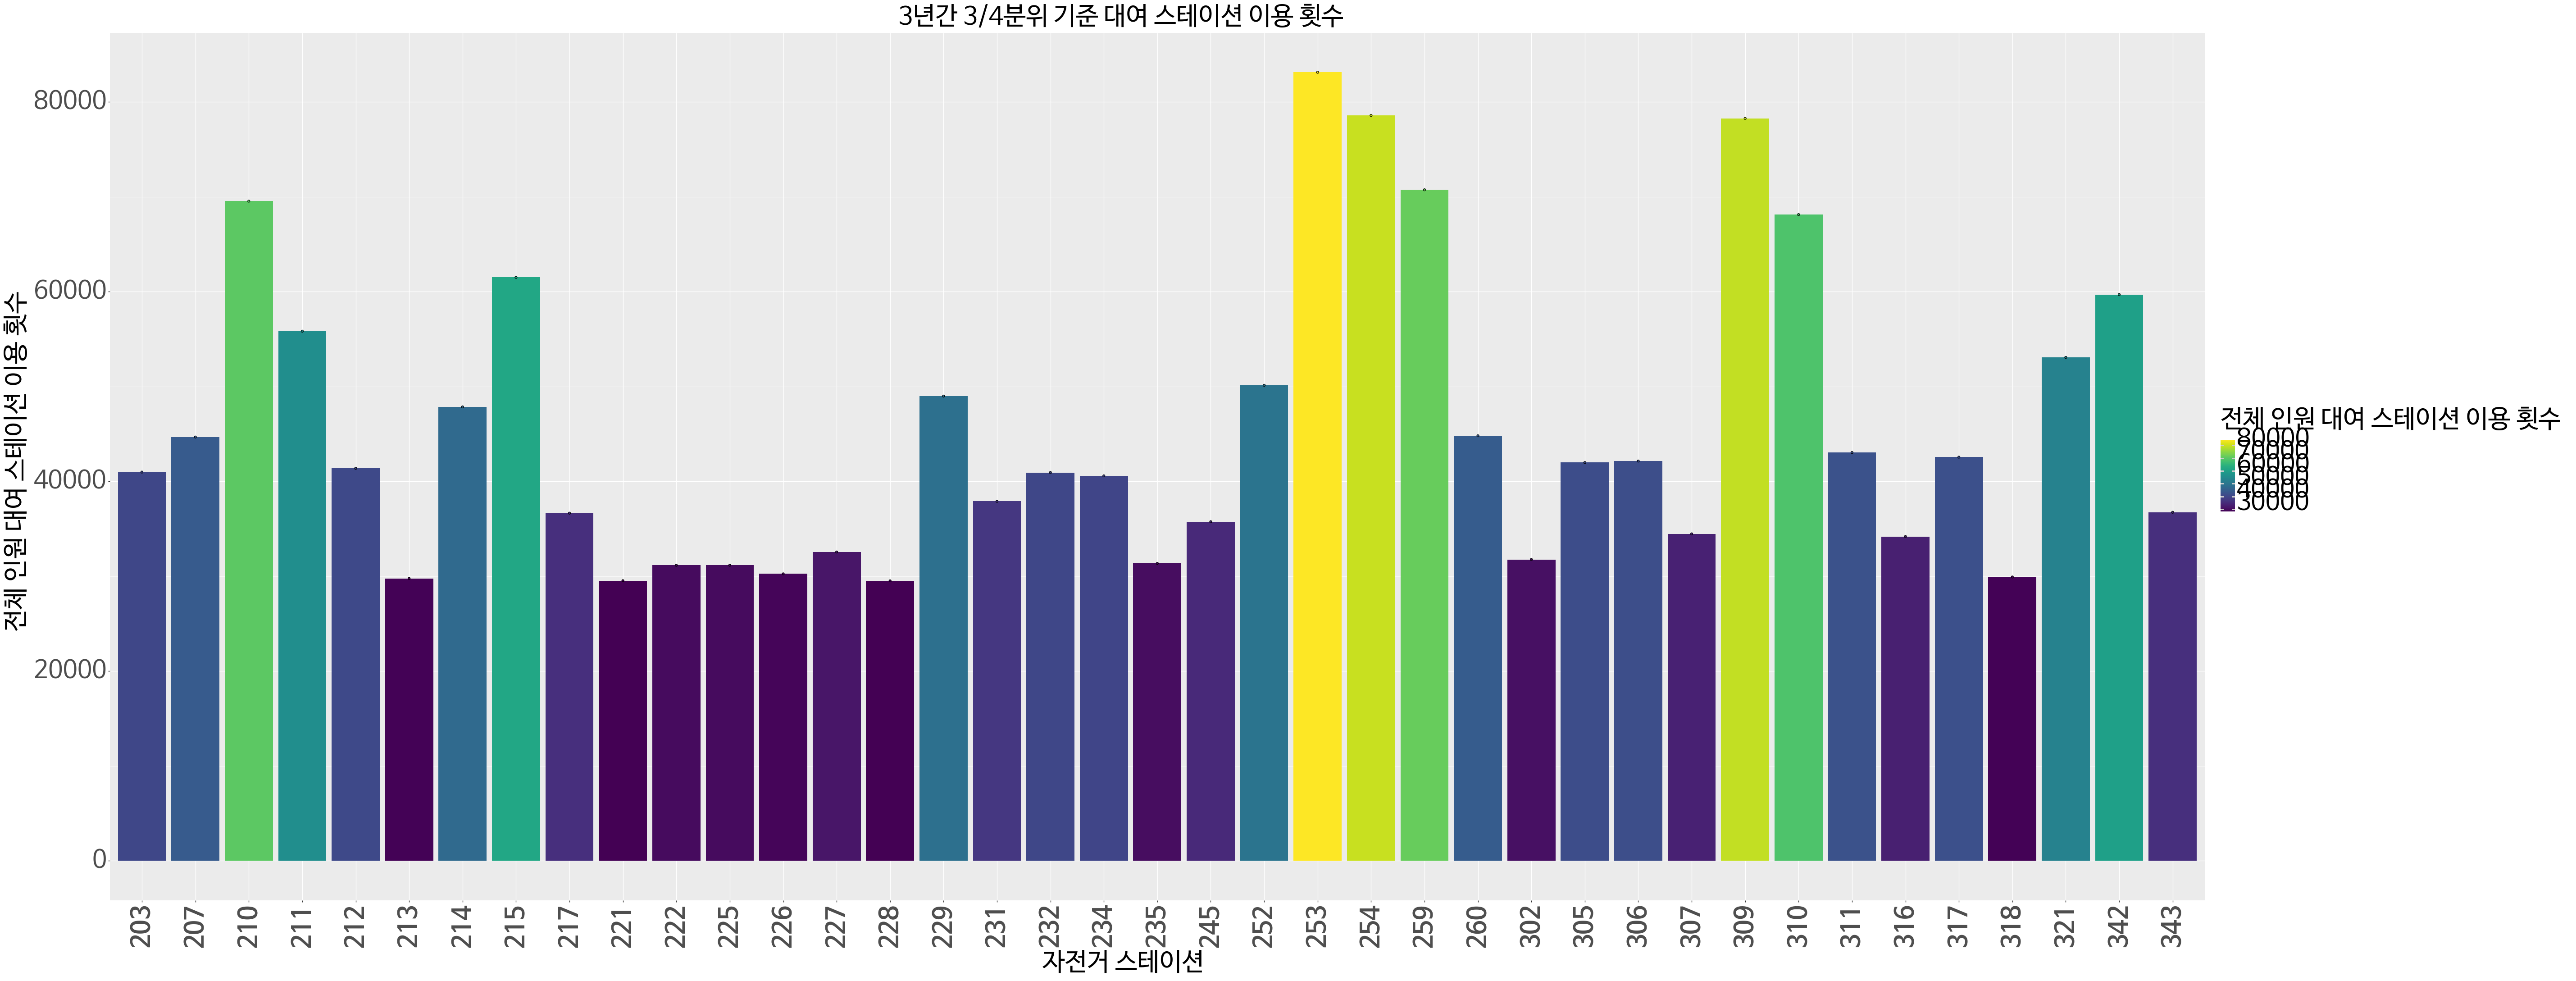

<ggplot: (-9223363307335346509)>

In [ ]:
(ggplot(df_station_rent_count_third)
+ aes(x = '대여 스테이션 번호', y = '전체 인원 대여 스테이션 이용 횟수', fill = '전체 인원 대여 스테이션 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ labs(x='자전거 스테이션', y='전체 인원 대여 스테이션 이용 횟수', title = '3년간 3/4분위 기준 대여 스테이션 이용 횟수 ')
+ theme(text = element_text(family = "NanumBarunGothic",size=40), axis_text_x = element_text(size =40,face = 'bold',angle = 90), figure_size = (60,25))
)

In [ ]:
#frit quartile
df_station_rent_count_first = df_station_rent_count_end[df_station_rent_count_end['전체 인원 대여 스테이션 이용 횟수']<7870.500000]
df_station_rent_count_first

,대여 스테이션 번호,전체 인원 대여 스테이션 이용 횟수,회원 대여 스테이션 이용 횟수,비회원 대여 스테이션 이용 횟수
1,103,4535,2460,2075
3,105,2806,1930,876
4,106,4444,3349,1095
15,123,6459,4513,1946
18,126,6759,4992,1767
20,128,6223,3973,2250
24,133,4978,3566,1412
27,139,2622,1092,1530
28,140,6847,4239,2608
29,141,7291,5355,1936


In [ ]:
df_station_rent_count_first['전체 인원 대여 스테이션 이용 횟수'].mean()

4498.076923076923

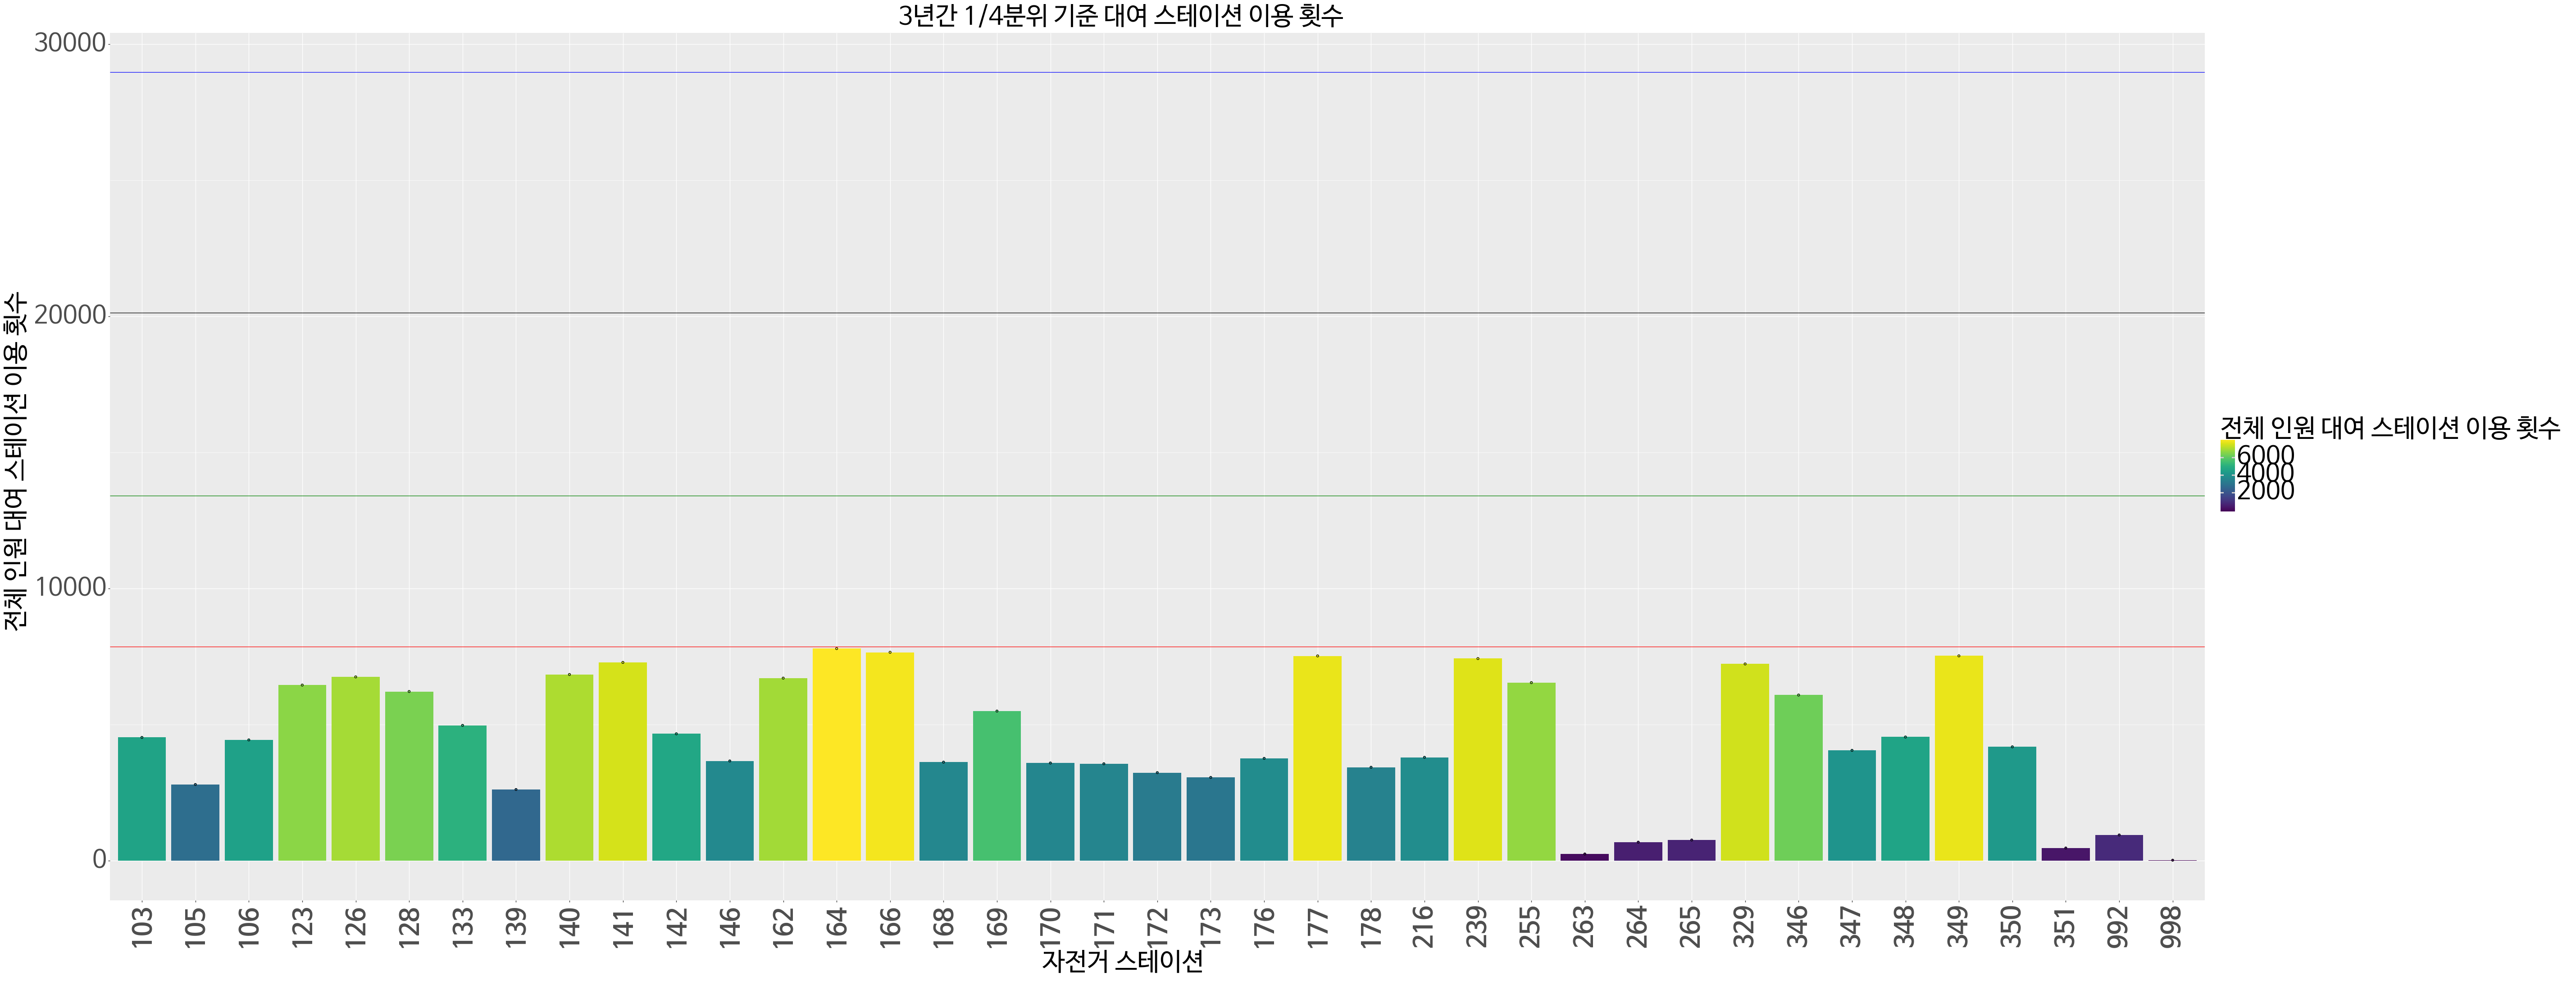

<ggplot: (-9223363307327091982)>

In [ ]:
(ggplot(df_station_rent_count_first)
+ aes(x = '대여 스테이션 번호', y = '전체 인원 대여 스테이션 이용 횟수', fill = '전체 인원 대여 스테이션 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ geom_hline(yintercept = 7870.500000,color='red',size=0.5) # 25
 + geom_hline(yintercept = 13411.500000	,color='green',size=0.5) #50
+ geom_hline(yintercept = 28972.000000	,color='blue',size=0.5) # 75
 + geom_hline(yintercept = 20145.435897, color='black',size=0.5) #평균
+ labs(x='자전거 스테이션', y='전체 인원 대여 스테이션 이용 횟수', title = '3년간 1/4분위 기준 대여 스테이션 이용 횟수 ')
+ theme(text = element_text(family = "NanumBarunGothic",size=40), axis_text_x = element_text(size =40,face = 'bold',angle = 90), figure_size = (60,25))
)

#### 3년간 반납 스테이션 시각화

In [ ]:
df_station_return_count_end

,반납 스테이션 번호,전체 인원 반납 스테이션 이용 횟수,회원 반납 스테이션 이용 횟수,비회원 반납 스테이션 이용 횟수
0,0,398234,311324,86910
1,101,9207,5726,3481
2,103,5121,2410,2711
3,104,9330,6801,2529
4,105,2696,1759,937
...,...,...,...,...
153,350,3662,2765,897
154,351,406,318,88
155,992,795,754,41
156,998,21,21,0


In [ ]:
df_station_return_count_end['반납 스테이션 번호'] = df_station_return_count_end[['반납 스테이션 번호']].astype('str')

In [ ]:
df_station_return_count_end.describe()

,전체 인원 반납 스테이션 이용 횟수,회원 반납 스테이션 이용 횟수,비회원 반납 스테이션 이용 횟수
count,158.000000,158.000000,158.000000
mean,19890.430380,14875.310127,5015.120253
std,34730.839154,26760.403766,9311.076169
min,10.000000,10.000000,0.000000
25%,6234.000000,4398.000000,1587.000000
50%,11040.500000,8330.500000,2966.000000
75%,24446.000000,19700.250000,4834.000000
max,398234.000000,311324.000000,86910.000000


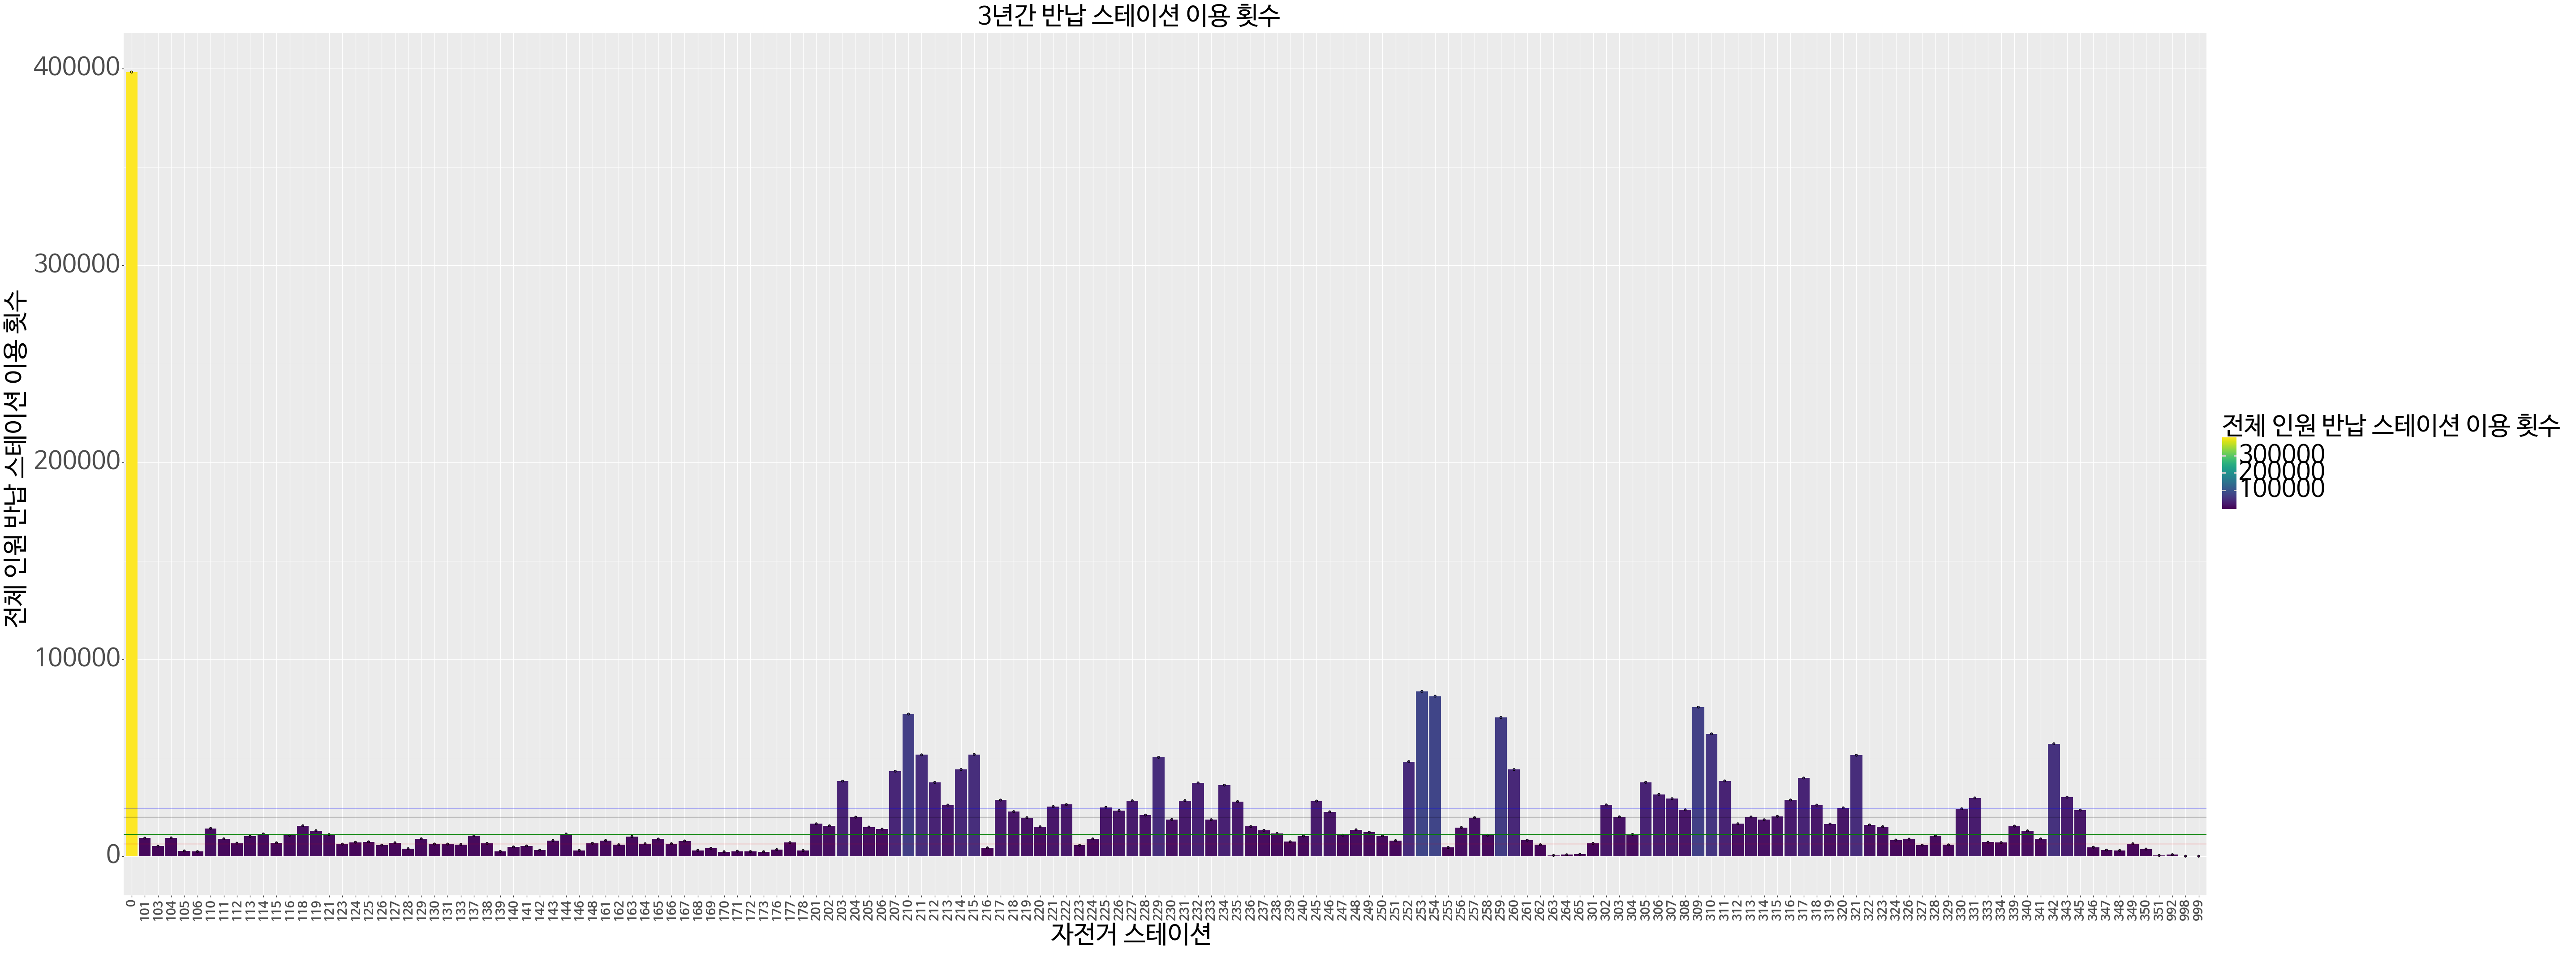

<ggplot: (-9223363307327118883)>

In [ ]:
(ggplot(df_station_return_count_end)
+ aes(x = '반납 스테이션 번호', y = '전체 인원 반납 스테이션 이용 횟수', fill = '전체 인원 반납 스테이션 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ geom_hline(yintercept = 6234.000000	,color='red',size=0.5) # 25
 + geom_hline(yintercept = 11040.500000		,color='green',size=0.5) #50
+ geom_hline(yintercept = 24446.000000	,color='blue',size=0.5) # 75
 + geom_hline(yintercept = 19890.430380, color='black',size=0.5) #평균
+ labs(x='자전거 스테이션', y='전체 인원 반납 스테이션 이용 횟수', title = '3년간 반납 스테이션 이용 횟수 ')
+ theme(text = element_text(family = "NanumBarunGothic",size=40), axis_text_x = element_text(size =20,face = 'bold',angle = 90), figure_size = (60,25))
)

In [ ]:
df_station_return_count_end_0x = df_station_return_count_end[1:]

In [ ]:
df_station_return_count_end_0x.describe() # 0번 스테이션을 제거한

,전체 인원 반납 스테이션 이용 횟수,회원 반납 스테이션 이용 횟수,비회원 반납 스테이션 이용 횟수
count,157.000000,157.000000,157.000000
mean,17480.598726,12987.101911,4493.496815
std,17044.943529,12400.665135,6632.188539
min,10.000000,10.000000,0.000000
25%,6201.000000,4393.000000,1579.000000
50%,10996.000000,8296.000000,2922.000000
75%,24092.000000,19449.000000,4828.000000
max,83718.000000,64714.000000,56155.000000


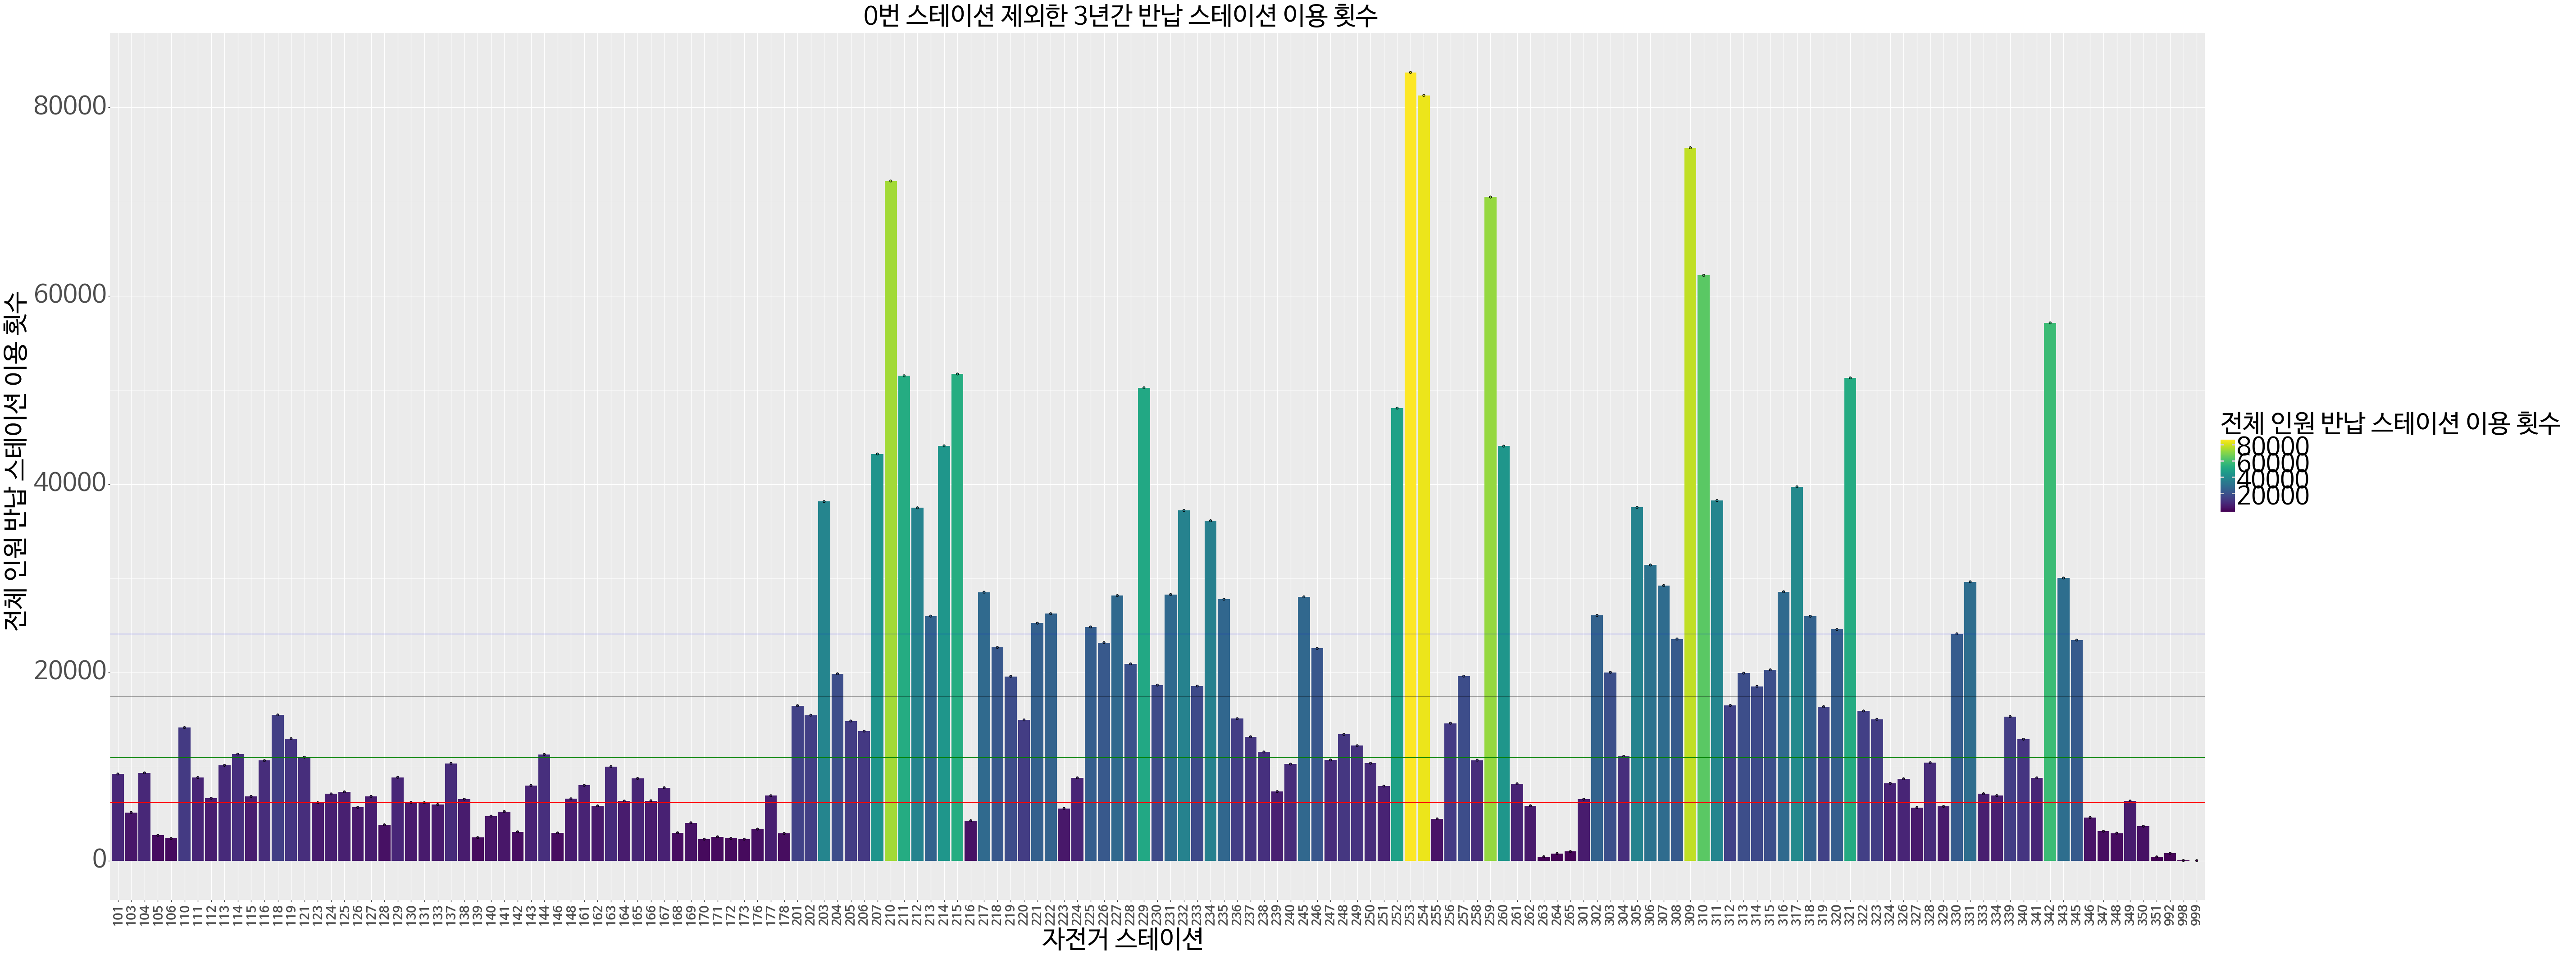

<ggplot: (8729518544676)>

In [ ]:
(ggplot(df_station_return_count_end_0x) # 반납 스테이션 0인것을 제외)
+ aes(x = '반납 스테이션 번호', y = '전체 인원 반납 스테이션 이용 횟수', fill = '전체 인원 반납 스테이션 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ geom_hline(yintercept = 6201.000000		,color='red',size=0.5) # 25
 + geom_hline(yintercept = 10996.000000		,color='green',size=0.5) #50
+ geom_hline(yintercept = 24092.000000	,color='blue',size=0.5) # 75
 + geom_hline(yintercept = 17480.598726, color='black',size=0.5) #평균
+ labs(x='자전거 스테이션', y='전체 인원 반납 스테이션 이용 횟수', title = '0번 스테이션 제외한 3년간 반납 스테이션 이용 횟수 ')
+ theme(text = element_text(family = "NanumBarunGothic",size=40), axis_text_x = element_text(size =20,face = 'bold',angle = 90), figure_size = (60,25))
)

In [ ]:
df_station_return_count_third = df_station_return_count_end_0x[df_station_return_count_end_0x['전체 인원 반납 스테이션 이용 횟수']>24446.000000]
df_station_return_count_third['전체 인원 반납 스테이션 이용 횟수'].mean()

41527.282051282054

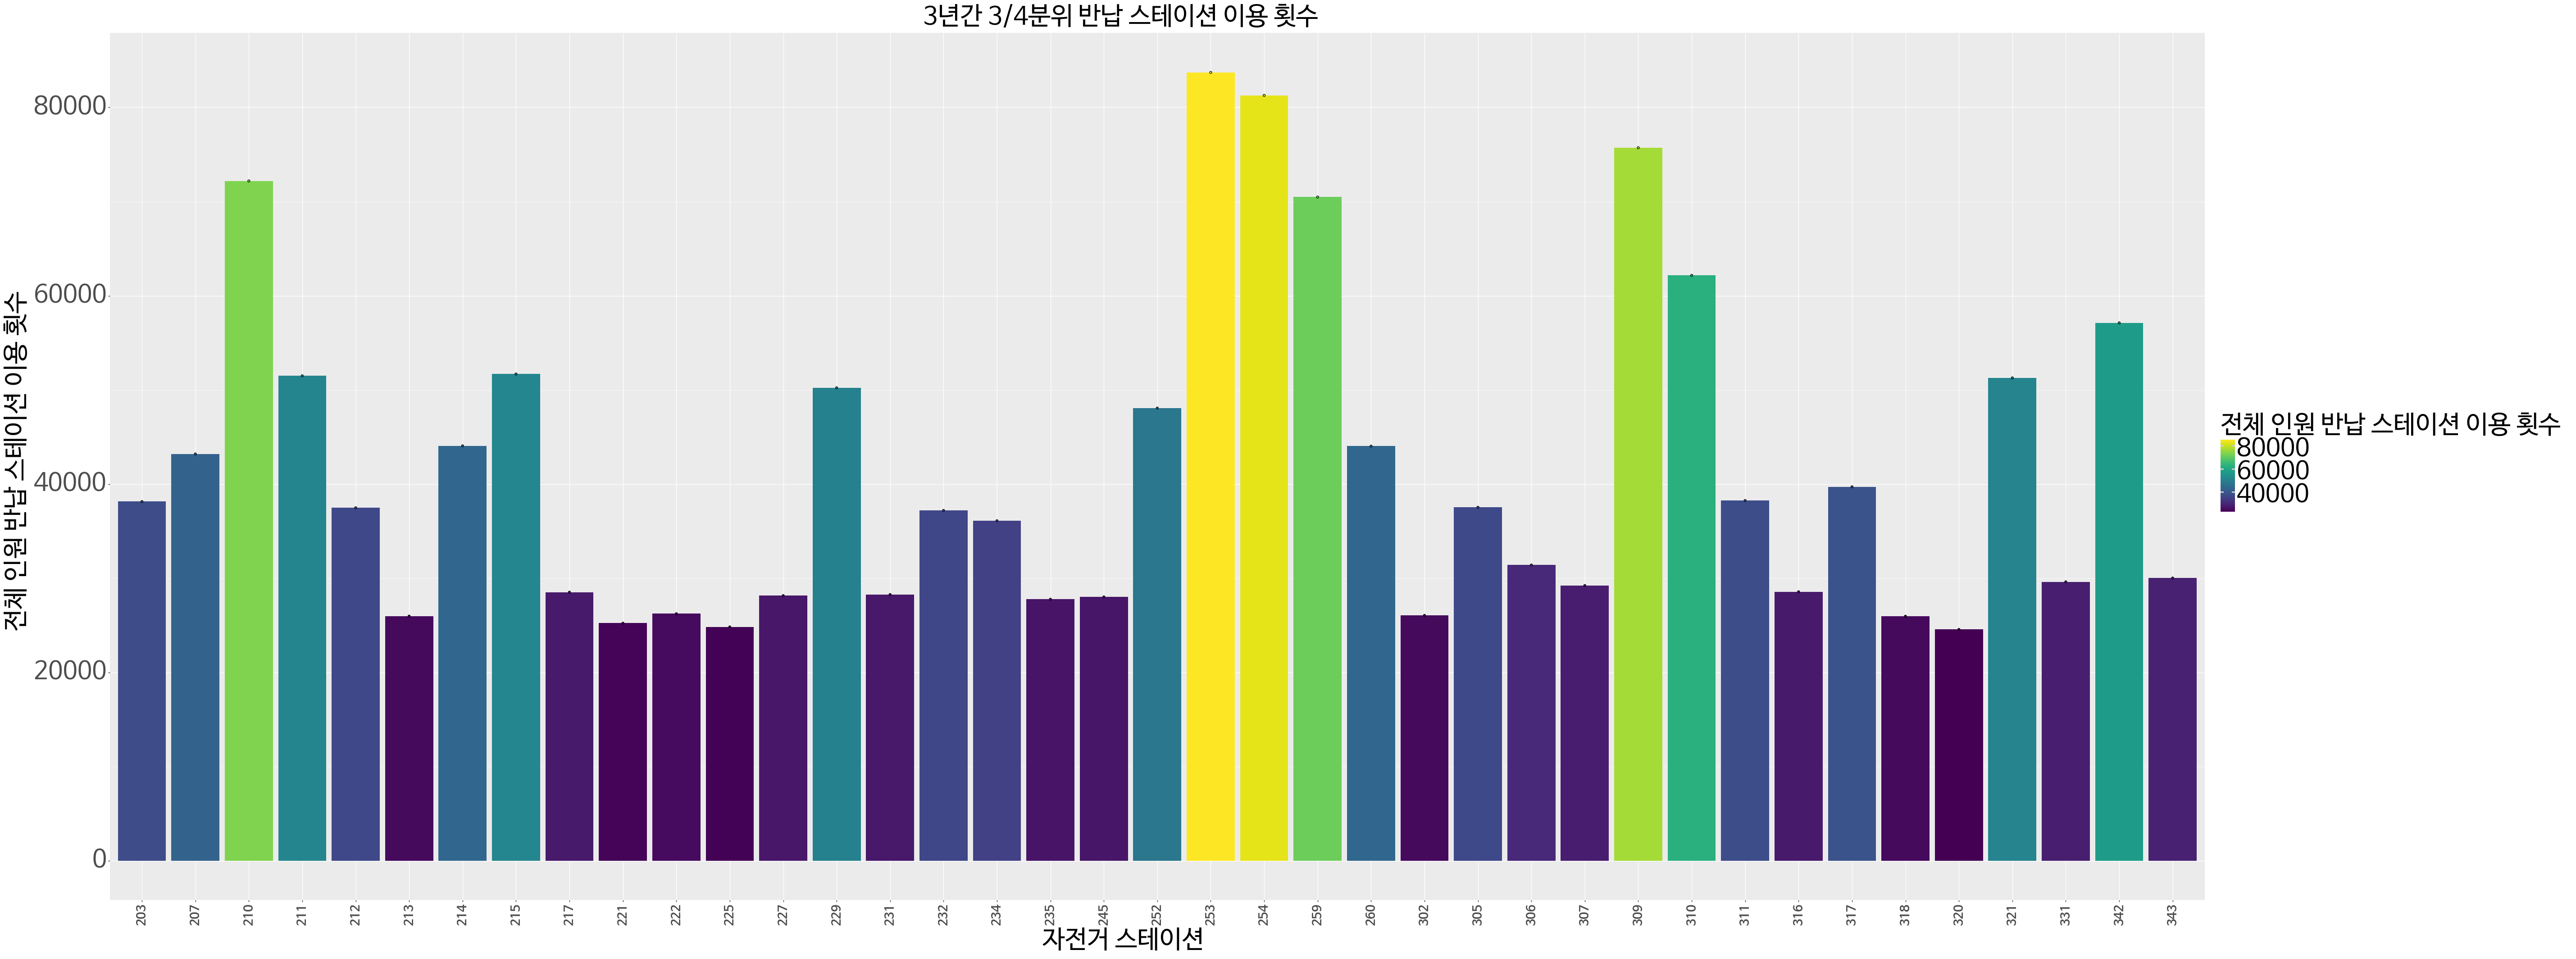

<ggplot: (8729519036743)>

In [ ]:
(ggplot(df_station_return_count_third) #반납 스테이션 0번 제외
+ aes(x = '반납 스테이션 번호', y = '전체 인원 반납 스테이션 이용 횟수', fill = '전체 인원 반납 스테이션 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ labs(x='자전거 스테이션', y='전체 인원 반납 스테이션 이용 횟수', title = '3년간 3/4분위 반납 스테이션 이용 횟수 ')
+ theme(text = element_text(family = "NanumBarunGothic",size=40), axis_text_x = element_text(size =20,face = 'bold',angle = 90), figure_size = (60,25))
)

In [ ]:
df_station_return_count_first = df_station_return_count_end_0x[df_station_return_count_end_0x['전체 인원 반납 스테이션 이용 횟수']<6201.000000]
df_station_return_count_first['전체 인원 반납 스테이션 이용 횟수'].mean()

3440.0

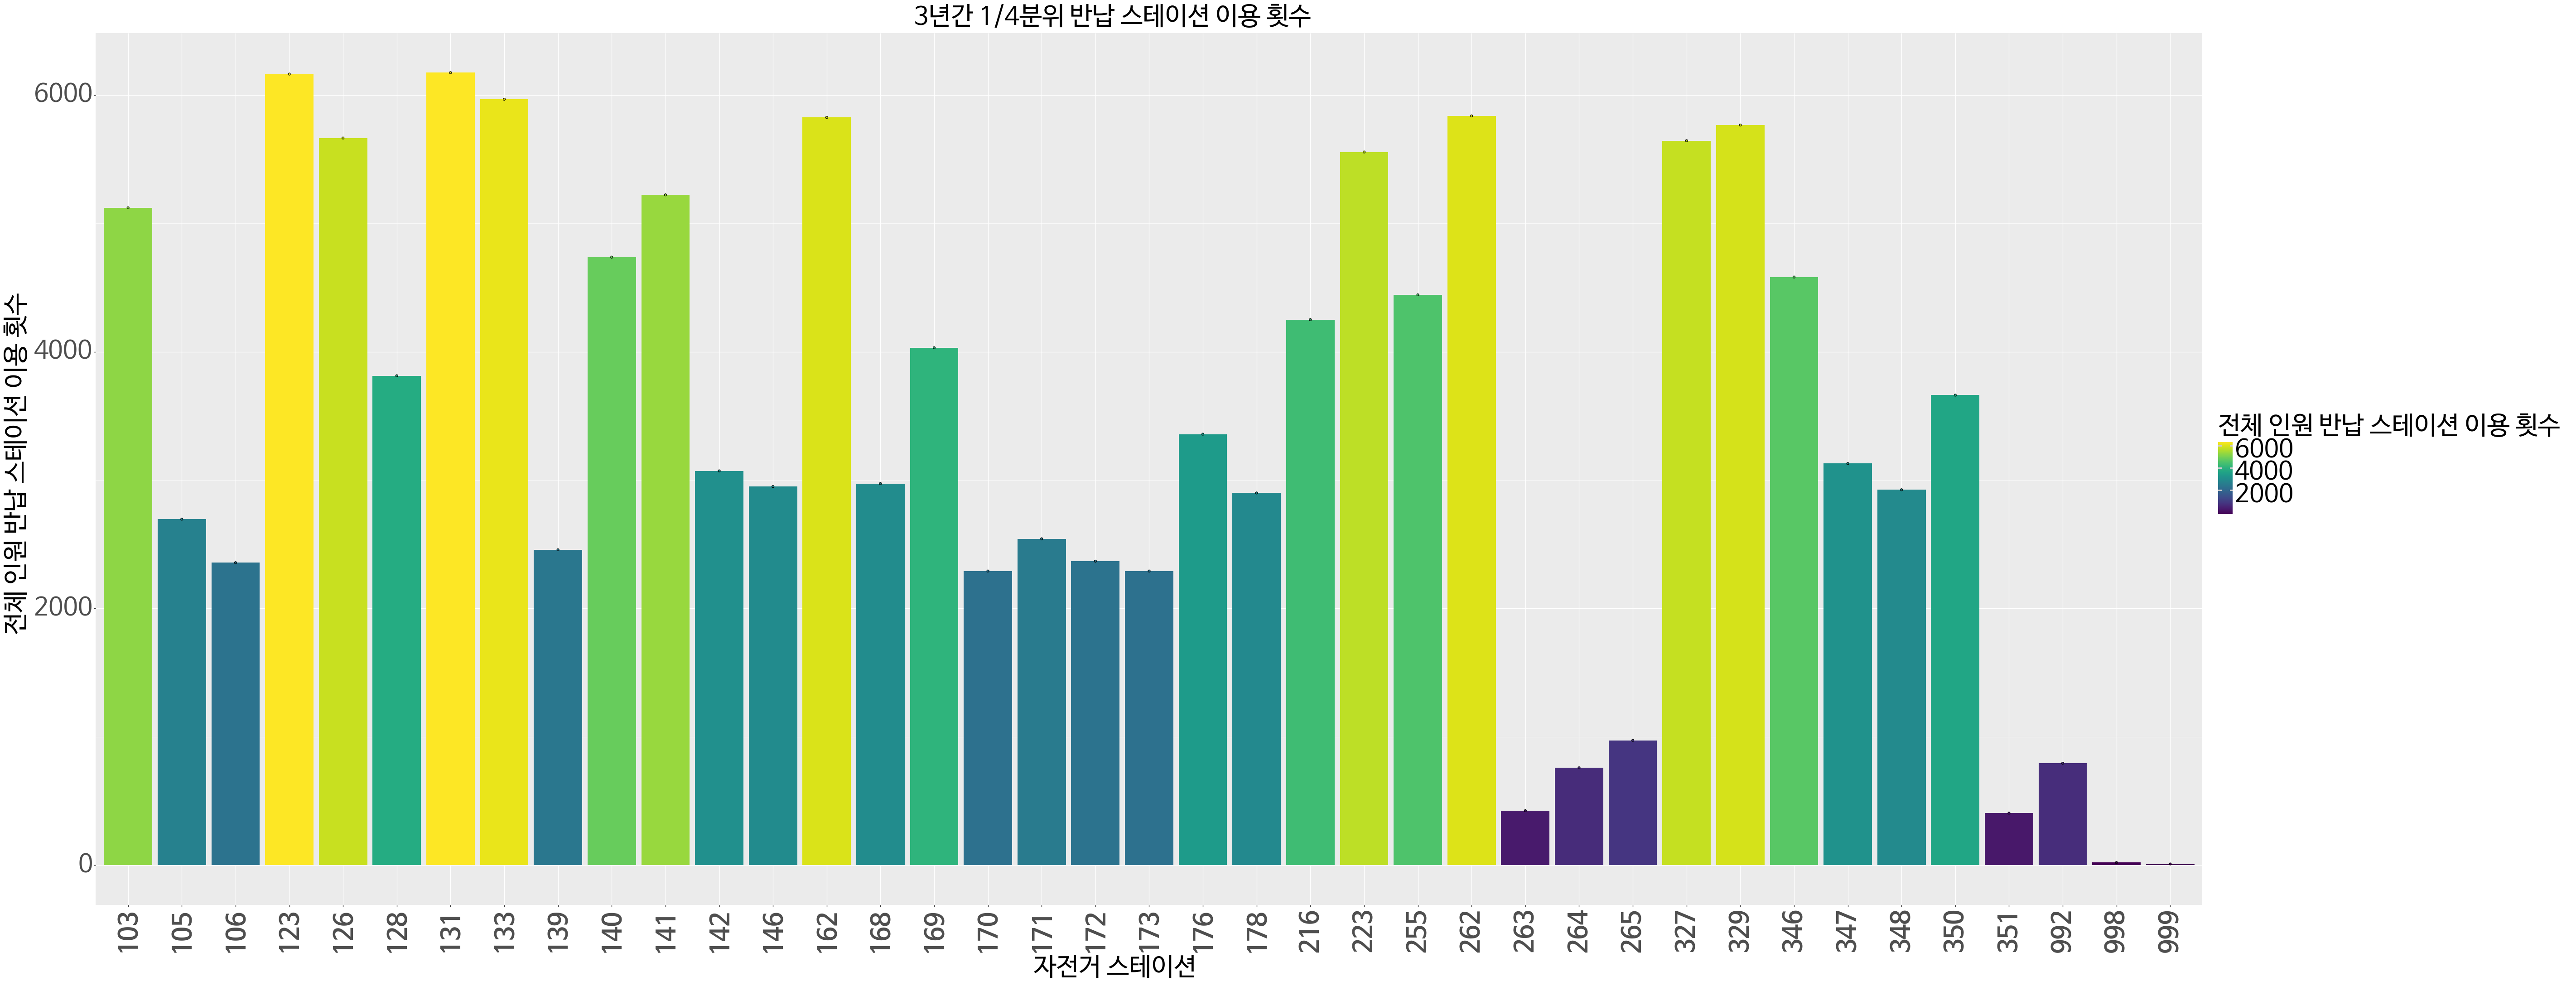

<ggplot: (8729519405744)>

In [ ]:
(ggplot(df_station_return_count_first)
+ aes(x = '반납 스테이션 번호', y = '전체 인원 반납 스테이션 이용 횟수', fill = '전체 인원 반납 스테이션 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ labs(x='자전거 스테이션', y='전체 인원 반납 스테이션 이용 횟수', title = '3년간 1/4분위 반납 스테이션 이용 횟수 ')
+ theme(text = element_text(family = "NanumBarunGothic",size=40), axis_text_x = element_text(size =40,face = 'bold',angle = 90), figure_size = (60,25))
)